# Federated Machine Learning in PyTorch

This notebook is a demonstration of _federated learning_, a type of machine learning in which a machine learning task is addressed using multiple devices, implemented in `pytorch`, a python implementation of the `torch` machine learning framework. This notebook is part of a series intended to start from the basics to demonstrate federated learning in pytorch, then move on to test some of the bounds of what federated learning can (and can't) do.

Now, let's talk about what we're going to see in _this_ notebook.

## The Task: Digit Recognition

For this demonstration, our task is a classic one: the MNIST digit recognition task. Specifically, we need to determine which number is written in an image of a handwritten digit like this one: 

![Handwritten digit "6"](images/example-6.png)

To carry out this task we need a machine learning model to "look" at an image and classify it into a number. We also need and image data to train the model. We're going to use a simple convolutional neural network model. For the training images, we're using the well-known MNIST digits dataset.

## The Approach: Federation

The federated approach uses several _worker_ devices to train their own local models with independent data. That is, the workers each train their own local model with a subset of the full dataset.

Each worker trains its local model for a bit, then sends its incrementally trained local model back to a _manager_. The manager combines the local models from all of the workers into a master model, then sends the master model back to the workers. This process is called a _round_. 

Then another round begins: the workers each train their local copy of the master model (creating another set of individualized local models), send those local models back to the manager. Once again the manager combines these individualized local models into a new master model, and pushes the new master model down to the workers. This cycle of rounds repeats as long as is necessary and useful.

## Our Federation Library

The `federated` library we're using here includes a `FederatedManager` class and a `FederatedWorker` class. A `FederatedManager` contains a master prediction model and creates several independent `FederatedWorker` instances. Each `FederatedWorker` has its own local model and a distinct subset of the MNIST data.

In each `round` of federated learning, each `FederatedWorker` trains its local model using only the data that that worker recieves, and then sends its trained local model to the `FederatedManager`. The `FederatedManager` combines the models into an updated master model and pushes that new master model down to each `FederatedWorker`.

We're going to see how federation works and test out some corner cases here. Let's get started with the code.

## The Basics

We need to load up the common elements to be used in the traditional and federated machine learning approaches. But we do a little housekeeping first to track performance of the code.

In [1]:
import time
import datetime

run_data = {} # used for code profiling

run_data['Date'] = datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
run_data['Global Start Time'] = time.time()

### The Model

Now we define the model. We're using a simple multilayer perceptron in the `torch` framework.

In [2]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST data, a training set and a test set. Nothing exciting to see here. This is our baseline. 

If you don't already have the MNIST data on your machine, the setting `download=True` in the call to `torchvision.datasets.MNIST()` will fetch the data for you.

In [3]:
# load the data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data

data_path = './MNIST-data/raw'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

Now we have our standard MNIST datasets: `train_dset` contains 60,000 examples, and `test_dset` contains 10,000 samples.

TODO: EXPLAIN WHY WE NORMALIZE THE DATA, AND WHY WE USE THOSE VALUES?

In [4]:
# create dataloaders

from torch.utils.data import DataLoader

run_data['Batch Size'] = batch_size = 256

# create standard dataloaders using all of the MNIST data - this is for baseline purposes
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

Let's check out the default data. The out-of-the-box MNIST dataset has roughly equal numbers of samples for each digit, i.e., about as many `4`s as `6`s.

The training data is reasonably well distributed, and the plots below confirm it. We scaled up the test set counts by a factor of six to make them comparable to the training set, which has exactly six times as many examples as the test set.

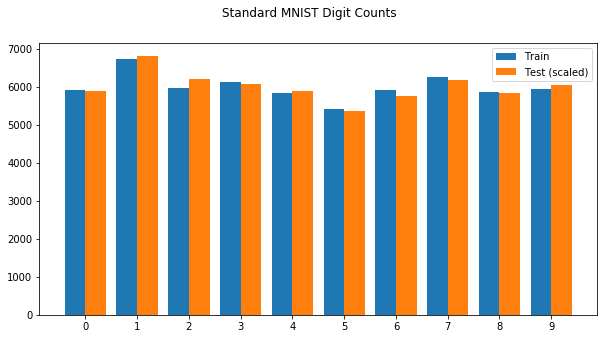

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Standard MNIST Digit Counts')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist([train_dloader.dataset.targets.tolist(), test_dloader.dataset.targets.tolist()*6], 
        label=['Train', 'Test (scaled)'],
        bins=list(range(11)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       )
ax.legend();

## Baseline: The Non-Federated Approach

To show a baseline of non-federated learning, we train a model using just one worker (we're technically using the federated library, but with one worker, it's equivalent to non-federated learning). This one worker will train on the full standard MNIST dataset of 60,000 examples.

TODO: AND THEN DO WE WANT TO SHOW A MODEL TRAINED ONLY ON ONE SKEWED DATASET?

TODO: Explain (and apologize?) the hack to measure the length of a dataset? Or find another way?

In [6]:
import federated

run_data['Learning Rate'] = learning_rate = 5e-2
run_data['Epochs per Round'] = num_epochs = 1
run_data['Nonfederated Training Rounds'] = num_rounds = 30

default_manager = federated.FederatedManager(
    [train_dloader],
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

print("Dataset size: ", len(train_dloader.dataset))
    
#_, ybatches = list(zip(*train_dloader))
#print("Dataset size:", len(torch.cat(ybatches)))

Dataset size:  60000


In [7]:
from tqdm import tqdm

print("Training", num_rounds, "round(s) with", default_manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

training_start_time = time.time()

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    default_manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % default_manager.manager_loss_history[-1], "\n")

run_data['Federated Training Time'] = time.time() - training_start_time
#run_data['Manager Loss History'] = default_manager.manager_loss_history
#run_data['Worker Loss Histories'] = default_manager.worker_loss_histories
run_data['Final Global Loss'] = default_manager.manager_loss_history[-1]

print('Federated Training Time: %.2f' % run_data['Federated Training Time'])

  0%|          | 0/30 [00:00<?, ?it/s]

Training 30 round(s) with 1 worker(s) doing 1 epoch(s) per round.

Beginning round 1
	Worker: 0344 	local loss: 0.74


  3%|▎         | 1/30 [00:17<08:13, 17.02s/it]

Finished round 1 with global loss: 0.54723 

Beginning round 2
	Worker: 0344 	local loss: 0.46


  7%|▋         | 2/30 [00:31<07:35, 16.27s/it]

Finished round 2 with global loss: 0.39299 

Beginning round 3
	Worker: 0344 	local loss: 0.41


 10%|█         | 3/30 [00:46<07:06, 15.81s/it]

Finished round 3 with global loss: 0.33005 

Beginning round 4
	Worker: 0344 	local loss: 0.41


 13%|█▎        | 4/30 [01:06<07:27, 17.21s/it]

Finished round 4 with global loss: 0.35574 

Beginning round 5
	Worker: 0344 	local loss: 0.34


 17%|█▋        | 5/30 [01:22<06:57, 16.70s/it]

Finished round 5 with global loss: 0.31310 

Beginning round 6
	Worker: 0344 	local loss: 0.24


 20%|██        | 6/30 [01:37<06:28, 16.19s/it]

Finished round 6 with global loss: 0.25618 

Beginning round 7
	Worker: 0344 	local loss: 0.24


 23%|██▎       | 7/30 [01:52<06:06, 15.92s/it]

Finished round 7 with global loss: 0.24172 

Beginning round 8
	Worker: 0344 	local loss: 0.19


 27%|██▋       | 8/30 [02:07<05:44, 15.66s/it]

Finished round 8 with global loss: 0.22283 

Beginning round 9
	Worker: 0344 	local loss: 0.18


 30%|███       | 9/30 [02:22<05:22, 15.37s/it]

Finished round 9 with global loss: 0.21613 

Beginning round 10
	Worker: 0344 	local loss: 0.19


 33%|███▎      | 10/30 [02:37<05:04, 15.25s/it]

Finished round 10 with global loss: 0.20225 

Beginning round 11
	Worker: 0344 	local loss: 0.17


 37%|███▋      | 11/30 [02:52<04:47, 15.11s/it]

Finished round 11 with global loss: 0.18232 

Beginning round 12
	Worker: 0344 	local loss: 0.29


 40%|████      | 12/30 [03:09<04:43, 15.76s/it]

Finished round 12 with global loss: 0.18504 

Beginning round 13
	Worker: 0344 	local loss: 0.13


 43%|████▎     | 13/30 [03:24<04:23, 15.49s/it]

Finished round 13 with global loss: 0.16242 

Beginning round 14
	Worker: 0344 	local loss: 0.11


 47%|████▋     | 14/30 [03:39<04:04, 15.29s/it]

Finished round 14 with global loss: 0.15864 

Beginning round 15
	Worker: 0344 	local loss: 0.20


 50%|█████     | 15/30 [03:53<03:47, 15.18s/it]

Finished round 15 with global loss: 0.15492 

Beginning round 16
	Worker: 0344 	local loss: 0.14


 53%|█████▎    | 16/30 [04:08<03:30, 15.07s/it]

Finished round 16 with global loss: 0.13969 

Beginning round 17
	Worker: 0344 	local loss: 0.19


 57%|█████▋    | 17/30 [04:23<03:14, 14.97s/it]

Finished round 17 with global loss: 0.13318 

Beginning round 18
	Worker: 0344 	local loss: 0.10


 60%|██████    | 18/30 [04:38<02:59, 14.92s/it]

Finished round 18 with global loss: 0.12695 

Beginning round 19
	Worker: 0344 	local loss: 0.12


 63%|██████▎   | 19/30 [04:53<02:44, 14.92s/it]

Finished round 19 with global loss: 0.12458 

Beginning round 20
	Worker: 0344 	local loss: 0.20


 67%|██████▋   | 20/30 [05:10<02:35, 15.59s/it]

Finished round 20 with global loss: 0.13251 

Beginning round 21
	Worker: 0344 	local loss: 0.11


 70%|███████   | 21/30 [05:25<02:18, 15.34s/it]

Finished round 21 with global loss: 0.11442 

Beginning round 22
	Worker: 0344 	local loss: 0.10


 73%|███████▎  | 22/30 [05:40<02:01, 15.20s/it]

Finished round 22 with global loss: 0.13174 

Beginning round 23
	Worker: 0344 	local loss: 0.09


 77%|███████▋  | 23/30 [05:55<01:46, 15.22s/it]

Finished round 23 with global loss: 0.10916 

Beginning round 24
	Worker: 0344 	local loss: 0.05


 80%|████████  | 24/30 [06:12<01:34, 15.78s/it]

Finished round 24 with global loss: 0.10179 

Beginning round 25
	Worker: 0344 	local loss: 0.08


 83%|████████▎ | 25/30 [06:28<01:20, 16.03s/it]

Finished round 25 with global loss: 0.10931 

Beginning round 26
	Worker: 0344 	local loss: 0.11


 87%|████████▋ | 26/30 [06:45<01:04, 16.09s/it]

Finished round 26 with global loss: 0.11778 

Beginning round 27
	Worker: 0344 	local loss: 0.06


 90%|█████████ | 27/30 [07:04<00:50, 16.90s/it]

Finished round 27 with global loss: 0.10362 

Beginning round 28
	Worker: 0344 	local loss: 0.12


 93%|█████████▎| 28/30 [07:18<00:32, 16.27s/it]

Finished round 28 with global loss: 0.09453 

Beginning round 29
	Worker: 0344 	local loss: 0.10


 97%|█████████▋| 29/30 [07:34<00:15, 15.95s/it]

Finished round 29 with global loss: 0.10627 

Beginning round 30
	Worker: 0344 	local loss: 0.11


100%|██████████| 30/30 [07:49<00:00, 15.77s/it]

Finished round 30 with global loss: 0.08750 

Federated Training Time: 469.38


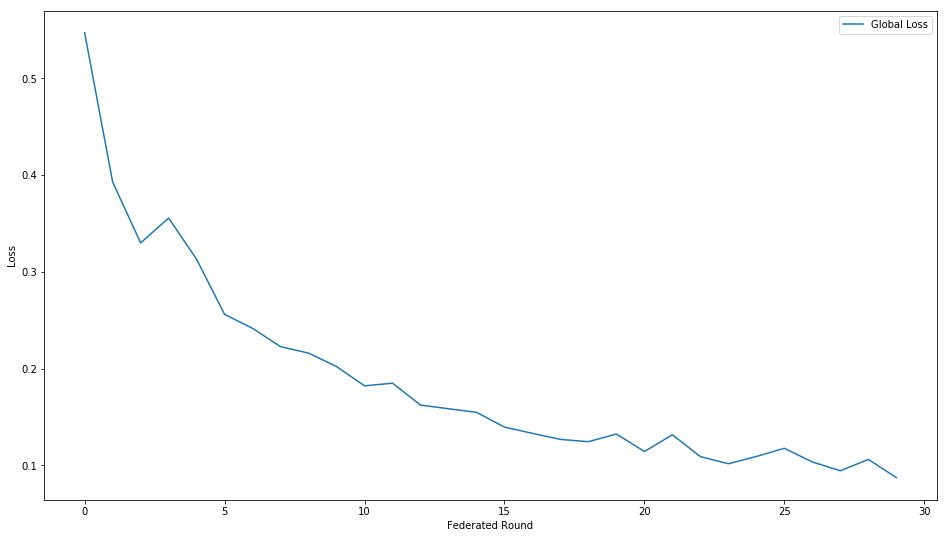

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig_default, ax_default = plt.subplots(figsize=(16, 9))
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax_default.plot(default_manager.manager_loss_history[1::2], label="Global Loss", )
ax_default.set_xlabel("Round")
ax_default.set_ylabel("Loss")
ax_default.legend();

# The Federated Approach

Now that we have a baseline using the traditional approach. we perform the same task using the federated learning approach.

## Splitting the Deck Into Piles

To illustrate federated learning we use several workers, each representing a device in the field. For now, we'll assume our workers are exposed to similar types and amounts of data, say, a thermostat reporting temperature and humidity every ten minutes. The analog here in MNIST is a subset of training examples for each worker. Here, we'll use ten workers. Our `pytorch` implementation will create a training `DataLoader` for each worker (and we we'll leave the test `DataLoader` as it is in the raw MNIST `Dataset`.

In [9]:
#from torch.utils.data import WeightedRandomSampler
#whitmans_sampler = WeightedRandomSampler([0.2, 0.14, 0.19], 24, replacement=False)

from torch.utils.data import RandomSampler

num_workers = 10
samples_per_worker = 6000
fed_constant_n_dloaders = []

fed_constant_n_sampler = RandomSampler(
    data_source=train_dset,
    replacement= True,
    num_samples=samples_per_worker,
    )

for i in tqdm(range(num_workers)):
    fed_constant_n_dloaders.append(DataLoader(
        train_dset, 
        batch_size=batch_size, 
        sampler=fed_constant_n_sampler,
    ))

100%|██████████| 10/10 [00:00<00:00, 9228.39it/s]


In [10]:
for i in range(len(fed_constant_n_dloaders)):
    _, ybatches = list(zip(*fed_constant_n_dloaders[7]))
    print('Dataloader', i, 'sample count:', len(torch.cat(ybatches)))

Dataloader 0 sample count: 6000
Dataloader 1 sample count: 6000
Dataloader 2 sample count: 6000
Dataloader 3 sample count: 6000
Dataloader 4 sample count: 6000
Dataloader 5 sample count: 6000
Dataloader 6 sample count: 6000
Dataloader 7 sample count: 6000
Dataloader 8 sample count: 6000
Dataloader 9 sample count: 6000


In [11]:
from collections import Counter
import numpy as np

hist_counts = []
digit_counts = []
for loader in tqdm(fed_constant_n_dloaders):
    _, ybatches = list(zip(*loader))
    ys = torch.cat(ybatches)
    ys = [int(y) for y in ys]
    hist_counts.append(ys)
    
    digits = sorted(Counter(ys).most_common())
    _, digits = list(zip(*digits))
    digit_counts.append(list(digits))

digit_counts = [list(i) for i in zip(*digit_counts)]

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


In [12]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(digit_counts)

print(fed_constant_n_dloaders[0].dataset.__len__)

for i in range(len(fed_constant_n_dloaders)):
    
    print(sum(digit_counts[i]))
    

[   [546, 584, 591, 607, 610, 593, 616, 619, 578, 600],
    [681, 734, 695, 699, 662, 668, 634, 664, 681, 681],
    [645, 594, 599, 641, 612, 597, 589, 608, 607, 615],
    [583, 591, 598, 602, 617, 572, 611, 631, 649, 599],
    [612, 608, 559, 604, 602, 602, 617, 551, 603, 578],
    [567, 536, 536, 518, 549, 527, 526, 558, 532, 546],
    [583, 590, 649, 584, 602, 583, 592, 602, 594, 551],
    [630, 612, 613, 613, 597, 655, 623, 620, 623, 633],
    [561, 589, 568, 545, 558, 624, 590, 588, 550, 574],
    [592, 562, 592, 587, 591, 579, 602, 559, 583, 623]]
<bound method MNIST.__len__ of Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./MNIST-data/raw
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(1.0,))
                         )
    Target Transforms (if any): None>
5944
6799
6107
6053
5936
5395
5930
6219
5747
5870


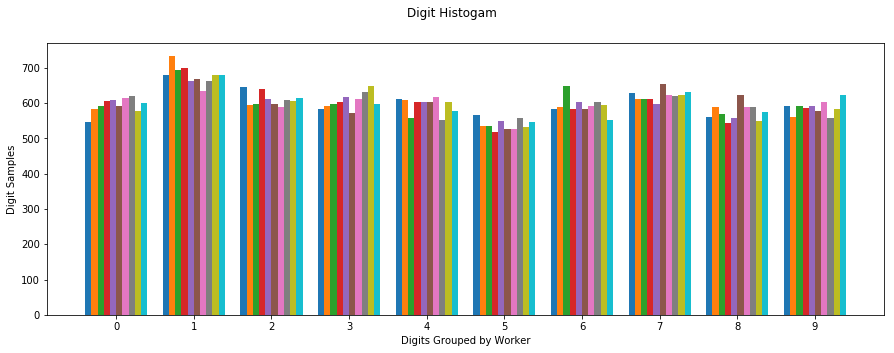

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Digit Histogam')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_ylabel('Digit Samples')
ax.set_xlabel('Digits Grouped by Worker')
H = ax.hist(hist_counts, bins=range(11), histtype='bar', align='left', rwidth=0.8)


##TODO CONFIRM WHAT IM SEEING HERE

So we can see that each of our ten workers has about the same number of each digit. I.e. worker 4 has about the same number of samples of `6`s as `9`s as `0`s.

In [14]:
import federated

run_data['Learning Rate'] = learning_rate = 5e-2
run_data['Epochs per Round'] = num_epochs = 1
run_data['Federated Training Rounds'] = num_rounds = 30

fed_constant_n_manager = federated.FederatedManager(
    fed_constant_n_dloaders,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [15]:
from tqdm import tqdm

print("Training", num_rounds, "round(s) with", fed_constant_n_manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

training_start_time = time.time()

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    fed_constant_n_manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % fed_constant_n_manager.manager_loss_history[-1], "\n")

run_data['Federated Training Time'] = time.time() - training_start_time
#run_data['Manager Loss History'] = default_manager.manager_loss_history
#run_data['Worker Loss Histories'] = default_manager.worker_loss_histories
run_data['Final Global Loss'] = fed_constant_n_manager.manager_loss_history[-1]

print('Federated Training Time: %.2f' % run_data['Federated Training Time'])

  0%|          | 0/30 [00:00<?, ?it/s]

Training 30 round(s) with 10 worker(s) doing 1 epoch(s) per round.

Beginning round 1
	Worker: 2616 	local loss: 2.22
	Worker: 4856 	local loss: 2.22
	Worker: 0856 	local loss: 2.23
	Worker: 3976 	local loss: 2.22
	Worker: 3304 	local loss: 2.22
	Worker: 5144 	local loss: 2.22
	Worker: 8392 	local loss: 2.23
	Worker: 7552 	local loss: 2.22
	Worker: 5760 	local loss: 2.20
	Worker: 9120 	local loss: 2.23


  3%|▎         | 1/30 [00:17<08:40, 17.96s/it]

Finished round 1 with global loss: 2.21626 

Beginning round 2
	Worker: 2616 	local loss: 2.08
	Worker: 4856 	local loss: 2.10
	Worker: 0856 	local loss: 2.12
	Worker: 3976 	local loss: 2.08
	Worker: 3304 	local loss: 2.05
	Worker: 5144 	local loss: 2.10
	Worker: 8392 	local loss: 2.10
	Worker: 7552 	local loss: 2.06
	Worker: 5760 	local loss: 2.12
	Worker: 9120 	local loss: 2.08


  7%|▋         | 2/30 [00:35<08:19, 17.85s/it]

Finished round 2 with global loss: 2.07727 

Beginning round 3
	Worker: 2616 	local loss: 1.84
	Worker: 4856 	local loss: 1.86
	Worker: 0856 	local loss: 1.83
	Worker: 3976 	local loss: 1.82
	Worker: 3304 	local loss: 1.82
	Worker: 5144 	local loss: 1.77
	Worker: 8392 	local loss: 1.85
	Worker: 7552 	local loss: 1.81
	Worker: 5760 	local loss: 1.84
	Worker: 9120 	local loss: 1.85


 10%|█         | 3/30 [00:55<08:20, 18.55s/it]

Finished round 3 with global loss: 1.80628 

Beginning round 4
	Worker: 2616 	local loss: 1.46
	Worker: 4856 	local loss: 1.48
	Worker: 0856 	local loss: 1.44
	Worker: 3976 	local loss: 1.42
	Worker: 3304 	local loss: 1.46
	Worker: 5144 	local loss: 1.41
	Worker: 8392 	local loss: 1.45
	Worker: 7552 	local loss: 1.42
	Worker: 5760 	local loss: 1.42
	Worker: 9120 	local loss: 1.44


 13%|█▎        | 4/30 [01:13<07:53, 18.23s/it]

Finished round 4 with global loss: 1.40529 

Beginning round 5
	Worker: 2616 	local loss: 1.07
	Worker: 4856 	local loss: 1.07
	Worker: 0856 	local loss: 1.13
	Worker: 3976 	local loss: 1.15
	Worker: 3304 	local loss: 1.15
	Worker: 5144 	local loss: 1.04
	Worker: 8392 	local loss: 1.09
	Worker: 7552 	local loss: 1.03
	Worker: 5760 	local loss: 1.11
	Worker: 9120 	local loss: 1.22


 17%|█▋        | 5/30 [01:30<07:32, 18.09s/it]

Finished round 5 with global loss: 1.06042 

Beginning round 6
	Worker: 2616 	local loss: 0.89
	Worker: 4856 	local loss: 0.91
	Worker: 0856 	local loss: 1.02
	Worker: 3976 	local loss: 0.92
	Worker: 3304 	local loss: 0.85
	Worker: 5144 	local loss: 0.82
	Worker: 8392 	local loss: 0.81
	Worker: 7552 	local loss: 0.75
	Worker: 5760 	local loss: 0.91
	Worker: 9120 	local loss: 0.82


 20%|██        | 6/30 [01:48<07:12, 18.00s/it]

Finished round 6 with global loss: 0.83894 

Beginning round 7
	Worker: 2616 	local loss: 0.65
	Worker: 4856 	local loss: 0.84
	Worker: 0856 	local loss: 0.76
	Worker: 3976 	local loss: 0.74
	Worker: 3304 	local loss: 0.70
	Worker: 5144 	local loss: 0.61
	Worker: 8392 	local loss: 0.83
	Worker: 7552 	local loss: 0.68
	Worker: 5760 	local loss: 0.67
	Worker: 9120 	local loss: 0.78


 23%|██▎       | 7/30 [02:07<06:55, 18.07s/it]

Finished round 7 with global loss: 0.70038 

Beginning round 8
	Worker: 2616 	local loss: 0.59
	Worker: 4856 	local loss: 0.63
	Worker: 0856 	local loss: 0.57
	Worker: 3976 	local loss: 0.64
	Worker: 3304 	local loss: 0.56
	Worker: 5144 	local loss: 0.65
	Worker: 8392 	local loss: 0.65
	Worker: 7552 	local loss: 0.72
	Worker: 5760 	local loss: 0.70
	Worker: 9120 	local loss: 0.74


 27%|██▋       | 8/30 [02:24<06:36, 18.02s/it]

Finished round 8 with global loss: 0.60996 

Beginning round 9
	Worker: 2616 	local loss: 0.71
	Worker: 4856 	local loss: 0.60
	Worker: 0856 	local loss: 0.73
	Worker: 3976 	local loss: 0.64
	Worker: 3304 	local loss: 0.59
	Worker: 5144 	local loss: 0.54
	Worker: 8392 	local loss: 0.43
	Worker: 7552 	local loss: 0.48
	Worker: 5760 	local loss: 0.67
	Worker: 9120 	local loss: 0.55


 30%|███       | 9/30 [02:43<06:22, 18.23s/it]

Finished round 9 with global loss: 0.54909 

Beginning round 10
	Worker: 2616 	local loss: 0.41
	Worker: 4856 	local loss: 0.56
	Worker: 0856 	local loss: 0.67
	Worker: 3976 	local loss: 0.46
	Worker: 3304 	local loss: 0.48
	Worker: 5144 	local loss: 0.49
	Worker: 8392 	local loss: 0.61
	Worker: 7552 	local loss: 0.46
	Worker: 5760 	local loss: 0.58
	Worker: 9120 	local loss: 0.64


 33%|███▎      | 10/30 [03:02<06:11, 18.57s/it]

Finished round 10 with global loss: 0.50694 

Beginning round 11
	Worker: 2616 	local loss: 0.60
	Worker: 4856 	local loss: 0.40
	Worker: 0856 	local loss: 0.61
	Worker: 3976 	local loss: 0.39
	Worker: 3304 	local loss: 0.60
	Worker: 5144 	local loss: 0.46
	Worker: 8392 	local loss: 0.56
	Worker: 7552 	local loss: 0.50
	Worker: 5760 	local loss: 0.63
	Worker: 9120 	local loss: 0.66


 37%|███▋      | 11/30 [03:20<05:47, 18.27s/it]

Finished round 11 with global loss: 0.47146 

Beginning round 12
	Worker: 2616 	local loss: 0.45
	Worker: 4856 	local loss: 0.44
	Worker: 0856 	local loss: 0.41
	Worker: 3976 	local loss: 0.64
	Worker: 3304 	local loss: 0.44
	Worker: 5144 	local loss: 0.41
	Worker: 8392 	local loss: 0.53
	Worker: 7552 	local loss: 0.39
	Worker: 5760 	local loss: 0.42
	Worker: 9120 	local loss: 0.45


 40%|████      | 12/30 [03:38<05:26, 18.13s/it]

Finished round 12 with global loss: 0.44821 

Beginning round 13
	Worker: 2616 	local loss: 0.36
	Worker: 4856 	local loss: 0.37
	Worker: 0856 	local loss: 0.55
	Worker: 3976 	local loss: 0.52
	Worker: 3304 	local loss: 0.48
	Worker: 5144 	local loss: 0.42
	Worker: 8392 	local loss: 0.47
	Worker: 7552 	local loss: 0.39
	Worker: 5760 	local loss: 0.36
	Worker: 9120 	local loss: 0.43


 43%|████▎     | 13/30 [03:56<05:05, 17.98s/it]

Finished round 13 with global loss: 0.42984 

Beginning round 14
	Worker: 2616 	local loss: 0.49
	Worker: 4856 	local loss: 0.41
	Worker: 0856 	local loss: 0.44
	Worker: 3976 	local loss: 0.51
	Worker: 3304 	local loss: 0.49
	Worker: 5144 	local loss: 0.42
	Worker: 8392 	local loss: 0.47
	Worker: 7552 	local loss: 0.34
	Worker: 5760 	local loss: 0.51
	Worker: 9120 	local loss: 0.43


 47%|████▋     | 14/30 [04:13<04:44, 17.80s/it]

Finished round 14 with global loss: 0.41403 

Beginning round 15
	Worker: 2616 	local loss: 0.45
	Worker: 4856 	local loss: 0.39
	Worker: 0856 	local loss: 0.41
	Worker: 3976 	local loss: 0.45
	Worker: 3304 	local loss: 0.49
	Worker: 5144 	local loss: 0.26
	Worker: 8392 	local loss: 0.34
	Worker: 7552 	local loss: 0.65
	Worker: 5760 	local loss: 0.41
	Worker: 9120 	local loss: 0.34


 50%|█████     | 15/30 [04:31<04:28, 17.88s/it]

Finished round 15 with global loss: 0.40041 

Beginning round 16
	Worker: 2616 	local loss: 0.35
	Worker: 4856 	local loss: 0.37
	Worker: 0856 	local loss: 0.40
	Worker: 3976 	local loss: 0.43
	Worker: 3304 	local loss: 0.32
	Worker: 5144 	local loss: 0.38
	Worker: 8392 	local loss: 0.47
	Worker: 7552 	local loss: 0.59
	Worker: 5760 	local loss: 0.44
	Worker: 9120 	local loss: 0.37


 53%|█████▎    | 16/30 [04:51<04:20, 18.59s/it]

Finished round 16 with global loss: 0.38888 

Beginning round 17
	Worker: 2616 	local loss: 0.41
	Worker: 4856 	local loss: 0.49
	Worker: 0856 	local loss: 0.39
	Worker: 3976 	local loss: 0.41
	Worker: 3304 	local loss: 0.47
	Worker: 5144 	local loss: 0.24
	Worker: 8392 	local loss: 0.47
	Worker: 7552 	local loss: 0.39
	Worker: 5760 	local loss: 0.52
	Worker: 9120 	local loss: 0.41


 57%|█████▋    | 17/30 [05:09<03:58, 18.33s/it]

Finished round 17 with global loss: 0.37640 

Beginning round 18
	Worker: 2616 	local loss: 0.42
	Worker: 4856 	local loss: 0.32
	Worker: 0856 	local loss: 0.37
	Worker: 3976 	local loss: 0.35
	Worker: 3304 	local loss: 0.37
	Worker: 5144 	local loss: 0.32
	Worker: 8392 	local loss: 0.30
	Worker: 7552 	local loss: 0.40
	Worker: 5760 	local loss: 0.29
	Worker: 9120 	local loss: 0.38


 60%|██████    | 18/30 [05:27<03:38, 18.24s/it]

Finished round 18 with global loss: 0.36737 

Beginning round 19
	Worker: 2616 	local loss: 0.39
	Worker: 4856 	local loss: 0.35
	Worker: 0856 	local loss: 0.47
	Worker: 3976 	local loss: 0.36
	Worker: 3304 	local loss: 0.26
	Worker: 5144 	local loss: 0.39
	Worker: 8392 	local loss: 0.52
	Worker: 7552 	local loss: 0.35
	Worker: 5760 	local loss: 0.46
	Worker: 9120 	local loss: 0.34


 63%|██████▎   | 19/30 [05:45<03:18, 18.04s/it]

Finished round 19 with global loss: 0.35893 

Beginning round 20
	Worker: 2616 	local loss: 0.42
	Worker: 4856 	local loss: 0.48
	Worker: 0856 	local loss: 0.38
	Worker: 3976 	local loss: 0.39
	Worker: 3304 	local loss: 0.30
	Worker: 5144 	local loss: 0.33
	Worker: 8392 	local loss: 0.41
	Worker: 7552 	local loss: 0.37
	Worker: 5760 	local loss: 0.33
	Worker: 9120 	local loss: 0.37


 67%|██████▋   | 20/30 [06:02<02:59, 17.90s/it]

Finished round 20 with global loss: 0.35574 

Beginning round 21
	Worker: 2616 	local loss: 0.28
	Worker: 4856 	local loss: 0.36
	Worker: 0856 	local loss: 0.47
	Worker: 3976 	local loss: 0.33
	Worker: 3304 	local loss: 0.38
	Worker: 5144 	local loss: 0.41
	Worker: 8392 	local loss: 0.31
	Worker: 7552 	local loss: 0.39
	Worker: 5760 	local loss: 0.28
	Worker: 9120 	local loss: 0.25


 70%|███████   | 21/30 [06:23<02:49, 18.79s/it]

Finished round 21 with global loss: 0.34921 

Beginning round 22
	Worker: 2616 	local loss: 0.32
	Worker: 4856 	local loss: 0.44
	Worker: 0856 	local loss: 0.33
	Worker: 3976 	local loss: 0.23
	Worker: 3304 	local loss: 0.34
	Worker: 5144 	local loss: 0.30
	Worker: 8392 	local loss: 0.37
	Worker: 7552 	local loss: 0.40
	Worker: 5760 	local loss: 0.44
	Worker: 9120 	local loss: 0.27


 73%|███████▎  | 22/30 [06:44<02:36, 19.57s/it]

Finished round 22 with global loss: 0.34271 

Beginning round 23
	Worker: 2616 	local loss: 0.38
	Worker: 4856 	local loss: 0.31
	Worker: 0856 	local loss: 0.44
	Worker: 3976 	local loss: 0.44
	Worker: 3304 	local loss: 0.29
	Worker: 5144 	local loss: 0.33
	Worker: 8392 	local loss: 0.33
	Worker: 7552 	local loss: 0.37
	Worker: 5760 	local loss: 0.39
	Worker: 9120 	local loss: 0.29


 77%|███████▋  | 23/30 [07:04<02:16, 19.46s/it]

Finished round 23 with global loss: 0.33768 

Beginning round 24
	Worker: 2616 	local loss: 0.47
	Worker: 4856 	local loss: 0.34
	Worker: 0856 	local loss: 0.34
	Worker: 3976 	local loss: 0.40
	Worker: 3304 	local loss: 0.33
	Worker: 5144 	local loss: 0.33
	Worker: 8392 	local loss: 0.30
	Worker: 7552 	local loss: 0.31
	Worker: 5760 	local loss: 0.46
	Worker: 9120 	local loss: 0.62


 80%|████████  | 24/30 [07:22<01:55, 19.19s/it]

Finished round 24 with global loss: 0.33273 

Beginning round 25
	Worker: 2616 	local loss: 0.32
	Worker: 4856 	local loss: 0.26
	Worker: 0856 	local loss: 0.33
	Worker: 3976 	local loss: 0.28
	Worker: 3304 	local loss: 0.33
	Worker: 5144 	local loss: 0.33
	Worker: 8392 	local loss: 0.22
	Worker: 7552 	local loss: 0.29
	Worker: 5760 	local loss: 0.33
	Worker: 9120 	local loss: 0.29


 83%|████████▎ | 25/30 [07:42<01:36, 19.33s/it]

Finished round 25 with global loss: 0.32870 

Beginning round 26
	Worker: 2616 	local loss: 0.55
	Worker: 4856 	local loss: 0.38
	Worker: 0856 	local loss: 0.41
	Worker: 3976 	local loss: 0.38
	Worker: 3304 	local loss: 0.37
	Worker: 5144 	local loss: 0.29
	Worker: 8392 	local loss: 0.33
	Worker: 7552 	local loss: 0.41
	Worker: 5760 	local loss: 0.27
	Worker: 9120 	local loss: 0.33


 87%|████████▋ | 26/30 [08:02<01:18, 19.69s/it]

Finished round 26 with global loss: 0.32637 

Beginning round 27
	Worker: 2616 	local loss: 0.27
	Worker: 4856 	local loss: 0.36
	Worker: 0856 	local loss: 0.36
	Worker: 3976 	local loss: 0.36
	Worker: 3304 	local loss: 0.31
	Worker: 5144 	local loss: 0.42
	Worker: 8392 	local loss: 0.26
	Worker: 7552 	local loss: 0.27
	Worker: 5760 	local loss: 0.45
	Worker: 9120 	local loss: 0.53


 90%|█████████ | 27/30 [08:21<00:58, 19.39s/it]

Finished round 27 with global loss: 0.32156 

Beginning round 28
	Worker: 2616 	local loss: 0.28
	Worker: 4856 	local loss: 0.46
	Worker: 0856 	local loss: 0.23
	Worker: 3976 	local loss: 0.29
	Worker: 3304 	local loss: 0.31
	Worker: 5144 	local loss: 0.35
	Worker: 8392 	local loss: 0.35
	Worker: 7552 	local loss: 0.34
	Worker: 5760 	local loss: 0.39
	Worker: 9120 	local loss: 0.21


 93%|█████████▎| 28/30 [08:40<00:38, 19.17s/it]

Finished round 28 with global loss: 0.31848 

Beginning round 29
	Worker: 2616 	local loss: 0.38
	Worker: 4856 	local loss: 0.28
	Worker: 0856 	local loss: 0.57
	Worker: 3976 	local loss: 0.44
	Worker: 3304 	local loss: 0.35
	Worker: 5144 	local loss: 0.34
	Worker: 8392 	local loss: 0.55
	Worker: 7552 	local loss: 0.32
	Worker: 5760 	local loss: 0.28
	Worker: 9120 	local loss: 0.42


 97%|█████████▋| 29/30 [09:03<00:20, 20.38s/it]

Finished round 29 with global loss: 0.31769 

Beginning round 30
	Worker: 2616 	local loss: 0.29
	Worker: 4856 	local loss: 0.35
	Worker: 0856 	local loss: 0.47
	Worker: 3976 	local loss: 0.22
	Worker: 3304 	local loss: 0.27
	Worker: 5144 	local loss: 0.34
	Worker: 8392 	local loss: 0.28
	Worker: 7552 	local loss: 0.45
	Worker: 5760 	local loss: 0.47
	Worker: 9120 	local loss: 0.29


100%|██████████| 30/30 [09:22<00:00, 20.04s/it]

Finished round 30 with global loss: 0.31016 

Federated Training Time: 562.60


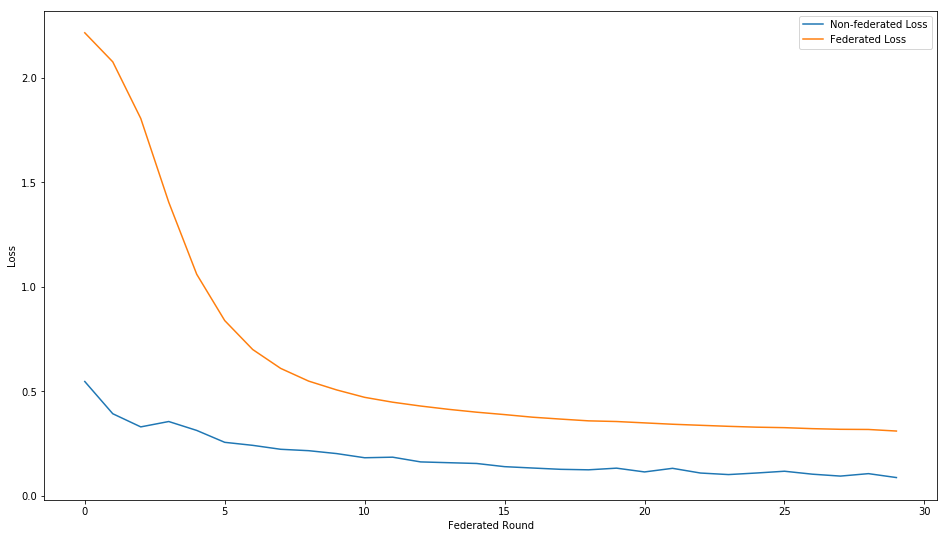

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

fig_default, ax_default = plt.subplots(figsize=(16, 9))

ax_default.plot(default_manager.manager_loss_history[1::2], label="Non-federated Loss", )


# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax_default.plot(fed_constant_n_manager.manager_loss_history[1::2], label="Federated Loss", )
ax_default.set_xlabel("Federated Round")
ax_default.set_ylabel("Loss")
ax_default.legend();

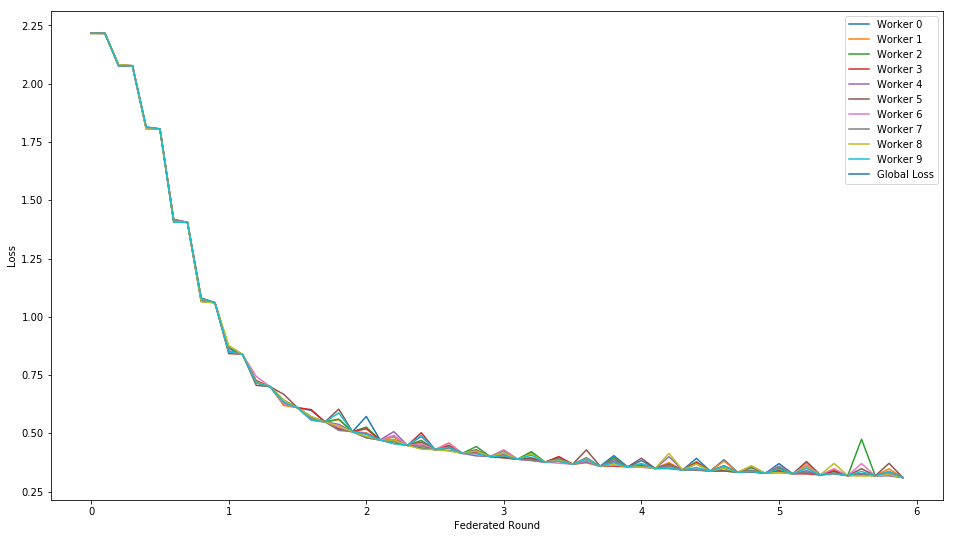

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))


for i in range(len(fed_constant_n_manager.worker_loss_histories)):
    ax.plot(fed_constant_n_manager.worker_loss_histories[i], label=('Worker ' + str(i)))

# TODO: Align the global loss properly
ax.plot(fed_constant_n_manager.manager_loss_history[1], label="Global Loss", )

    
# TODO: Get these labels done properly - they should be aligned with the main 
ax.set_xticklabels([(i-1) for i in range(len(fed_constant_n_manager.worker_loss_histories))])
ax.set_xlabel("Federated Round")
ax.set_ylabel("Loss")
ax.legend();

# Federation with Varying Example Counts

Now we've seen federation work with a dataset scattered across a number of workers. And we saw that its performance isn't substantially different from the non-federated approach, while decentralizing the work of training and limiting the amount of data transfered between the main manager and the workers.

But what if our workers don't have access to equal amounts of data? Let's explore that.

## Spliting the Deck into Uneven Piles

To test this, we need workers to have access to different numbers of training examples. So let's make a set of decks that gives each of our workers more or less training data than the others.

# Conclusion
TODO: WRAP UP THE BLOG POST HERE. EVERYTHING BELOW IS PART TWO OR THREE

# Blog Post Two

In our last post [LINK HERE] we showed how to implement federated learning in pytorch. In this post we get one step more realistic about how federated learning would play out in real life.

In federated learning, we expect that each of the workers captures and trains on somewhat different data. For example, my mobile phone will capture more songs in genres of music that I listen to, while your cell phone will reflect a different set of sings in different genres. Probably. If not, get out of my mind! [BENE GESSIRIT MOTHER IMAGE? SINGLE WHITE FEMALE IMAGE?] And there's likely a lot of overlap due to radios and clustering of popular songs.

To reflect this kind of data distribution, we're going to skew the MNIST data to reflect that each worker sees a somewhat different subset of the training data.

## Stacking the Deck (Skewing Data)

We know the baseline data is pretty even across numerals. Now we need a way to "stack the deck" of examples that each worker sees. This method creates a dataset that is randomly sampled from a given dataset with the random sampling biased according to a dictionary of weights for each label.

In [18]:
from torch.utils.data import WeightedRandomSampler

def stacked_dset(dset, label_weights, N):
    """
        dset: dataset
        label_weights = {dog: 0.5, cat: 0.3, ...}
        N: size of stacked dset
        return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])

#     for label in test_dset.targets:
#         weights.append(label_weights[int(label)])
# TODO / MLW : how to speed this up - currently takes about a minute to train ten stacked training sets
    
    return WeightedRandomSampler(weights, N, replacement=False)

And this is where we get the dictionary of weights. For simplicity's sake, we just take a list of labels to be sampled "normally" and the rest are biased against. So, preserving `3`s and skewing everything else by a factor of 0.9 shoud get a set of weights that results in a dataset that is slightly heavy on `3`s compared to everything else. In an an extreme example, preserving only `3`s, with a skew of 0, will produce weights that will yield a dataset of only `3`s.

In [19]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

### 

Here we do the sampling to create our skewed datasets.

In [20]:
# create stacked loaders for the workers

run_data['Skew Bias'] = skew_bias = 1
run_data['Examples Per Skewed Loader'] = loader_size = 60000
run_data['Number of Workers'] = num_workers = 1

stacking_start_time = time.time()

stacked_data_loaders = []
for label in tqdm(range(num_workers)):
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label%10], skew_bias), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

run_data['Stacking Time'] = time.time() - stacking_start_time
run_data['Stacking Time per Loader'] = run_data['Stacking Time'] / run_data['Number of Workers']

print('Stacking Time: %.2f' % run_data['Stacking Time'])
print('Stacking Time per Loader: %.2f' % run_data['Stacking Time per Loader'])

100%|██████████| 1/1 [00:11<00:00, 11.39s/it]

Stacking Time: 11.39
Stacking Time per Loader: 11.39


We should see the effect of the skew in a count and histogram of a skewed dataset. Here, we arbitrarily picked the second dataloader.

In [21]:
_, ybatches = list(zip(*stacked_data_loaders[0]))
print('Dataloader sample count:', len(torch.cat(ybatches)))

KeyboardInterrupt: 

In [ ]:
#for i in range(len(stacked_data_loaders)):
#    _, ybatches = list(zip(*stacked_data_loaders[i]))
#    print('Dataloader', i ,'sample count:', len(torch.cat(ybatches)))

In [ ]:
from collections import Counter
import numpy as np

hist_counts = []
digit_counts = []
for loader in tqdm(stacked_data_loaders):
    _, ybatches = list(zip(*loader))
    ys = torch.cat(ybatches)
    ys = [int(y) for y in ys]
    hist_counts.append(ys)
    
    digits = sorted(Counter(ys).most_common())
    _, digits = list(zip(*digits))
    digit_counts.append(list(digits))

digit_counts = [list(i) for i in zip(*digit_counts)]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Digit Skew Histogram')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_ylabel('Digit Count')
ax.set_xlabel('Digit')
H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew: Digit Counts by Worker')

pos = list(range(num_workers))
width = 0.08

for digit in range(10):
    ax.bar([p + (width * digit) for p in pos],
           digit_counts[digit],
           width = width,
           label = str(digit),
          )

ax.set_xticks([p + (4.5 * width) for p in pos])
ax.set_xticklabels([('Dataset ' + str(x)) for x in range(num_workers)])
ax.set_ylabel('Digit Samples')
ax.set_xlabel('Samples Grouped by Worker')
ax.legend(loc = 'upper right');

We create the `federatedManager` using the skewed training data. Note that we don't skew the test data -- we want to see how everything performs on a normal data distribution.

In [ ]:
import federated

run_data['Learning Rate'] = learning_rate = 1e-2
run_data['Epochs per Round'] = num_epochs = 1
run_data['Federated Training Rounds'] = num_rounds = 50

manager = federated.FederatedManager(
    stacked_data_loaders,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

Now let's do some rounds of federated training.

In [ ]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

training_start_time = time.time()

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    manager.round()
    print("Finished round", i+1, "with global loss: %.2f" % manager.manager_loss_history[-1], "\n")

run_data['Federated Training Time'] = time.time() - training_start_time
#run_data['Manager Loss History'] = manager.manager_loss_history
#run_data['Worker Loss Histories'] = manager.worker_loss_histories
run_data['Final Global Loss'] = manager.manager_loss_history[-1]

print('Federated Training Time: %.2f' % run_data['Federated Training Time'])

Now let's take a look at how the training went. Here's a graph of the loss per round.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss", )
ax.set_xlabel("Federated Round")
ax.set_ylabel("Loss")
ax.legend();

This looks pretty good, with loss dropping off just like we want. Perhaps it's a little bumpy because of the relatively fast training rate, but it should be improving on balance. But if we look under the hood at each individual worker's loss, we see that the workers' local models are diverging and converging at each round. They diverge because each local model trains on different data, resulting in a somewhat different loss per round. The converge again because the manager combines them into a master model, such that they all have the same loss as the global loss.

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))


for i in range(len(manager.worker_loss_histories)):
    ax.plot(manager.worker_loss_histories[i], label=('Worker ' + str(i)))

# TODO: Align the global loss properly
ax.plot(manager.manager_loss_history[1], label="Global Loss", )

    
# TODO: Get these labels done properly - they should be aligned with the main 
ax.set_xticklabels([(i-1) for i in range(len(manager.worker_loss_histories))])
ax.set_xlabel("Federated Round")
ax.set_ylabel("Loss")
ax.legend();

Ideas:
- plot performance on a given numeral for the main model next to that of a worker skewed against that numeral. Let both run without federation or run a few epochs before federation. Show this as a baseline
- histogram of numerals? More for curiosity, but shows spread of data that we might want to reflect in the baseline training.
- post 1: what's the accuracy loss for federation compared to baseline direct training?
- post 2: weird side stats
    - skew vs. accuracy
        - plot - x-axis = skew, y-axis = accuracy
    - run all to convergence, compare how long to reach comparable accuracy?
        - time or epochs necessary to reach comparable accuracy between federated and standard approach
        - time or epochs necessary to reach comparable accuracy by skew
    - run the federated version with balanced, but small sets of data

Questions:
- Why does the time spent by a worker on any given epoch all happen _before_ the batches start rolling in? What's happening there? Am I just spinning my wheels on something?
    - TODO: try this from a regular python file. The notebook may be buffering up those print statements in the batches
- Why does random selection of the skewed datasets take so long? Is it because they're without replacement?
- Why do all the workers and epochs always happen in order? Wouldn't my laptop parallelize them across cores? Is that too much to ask from an interpreter? Is the interpreter smarter than I am and actually is parallelizing them and the smartest way in to do them in order?
- why use ten workers? Why not fewer?

- TODO: unequal data volume at each worker. Try some workers with very small or very large samples.
- TODO: unequal numbers of samples across the whole set, e.g., we just have fewer `7`s and `4`s across the set, and a glut of `1`s





# Improvement Ideas

Global variables:
- Batch size
- Learning rate
- Epochs
- Total dataset size
- Worker dataset size
    - worker dataset size skew (variance among number of samples seen from worker to worker)
- Selection of data with or without replacement
- Dataset class skew (more or fewer examples from each class)

Targets:
- Loss
- Accuracy
- Runtime to target loss or accuracy

TODO: Write a bit of code that records the hyperparameters and saves the graphs, times and losses in a bundle for each run. Something like:

```
2019-05-06 21:02:50

# standard dataloader parameter
batch_size = 128

# biasing parameters
skew_bias = 0.3
loader_size = 8192
num_workers = 10

Stacked set creation time: 00:01:08

# training parameters
learning_rate = 1e-2
num_epochs = 1
num_rounds = 20

Train time = 00:43:02

Final global loss: 0.48251
```

Well. I did this. And now the code is unreadable.

In [ ]:
# a little performance info on the run
run_data['Global End Time'] = time.time()
run_data['Global Time'] = run_data['Global End Time'] - run_data['Global Start Time']
run_data

In [ ]:
# leave a record of the run
# but it isn't valid JSON
import json 
with open('run_data.json', 'a') as file:
    file.write(json.dumps(run_data))
    file.write('\n\n')

In [ ]:
from collections import Counter
import numpy as np

train_counts = Counter(int(y) for y in train_dset.targets).most_common()
print("Train digit counts: \n", train_counts)
print("Train count standard deviation: %.2f" % np.std(list(zip(*train_counts))[1]))
print("Train count coefficient of variation: %.2f" 
      % (float(np.mean(list(zip(*train_counts))[1])) / float(np.std(list(zip(*train_counts))[1]))))

print()

test_counts = Counter(int(y) for y in test_dset.targets).most_common()
print("Test digit counts: \n", test_counts)
print("Test standard deviation: %.2f" % np.std(list(zip(*test_counts))[1]))
print("Test count coefficient of variation: %.2f" 
      % (float(np.mean(list(zip(*test_counts))[1])) / float(np.std(list(zip(*test_counts))[1]))))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Digit Counts at each Worker')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xticklabels([('Digit ' + str(x-1)) for x in range(11)])
ax.hist(hist_counts, 
        label=[('Worker ' + str(x)) for x in range(num_workers)],
        bins=list(range(12)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       );
ax.legend();